# Setup
## Modules

In [59]:
# os manipulation
import os

# data manipulation
import pandas as pd
import numpy as np

# ml training
from sklearn.model_selection import KFold

# misc
import matplotlib.pyplot as plt
from itertools import product

# magic functions
%matplotlib inline 


## Useful Functions

In [28]:
def downcast_dtypes(df):
    '''
    `float64` type to `float32`
    `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


___

# ETL
## Raw Data

The dataset we are going to use is taken from the competition, that serves as the final project for this course. You can find complete data description at the [competition web page](https://www.kaggle.com/c/competitive-data-science-final-project/data). To join the competition use [this link](https://www.kaggle.com/t/1ea93815dca248e99221df42ebde3540).


In [2]:
DATA_FOLDER = '../data/final_project_data/'

transactions_raw = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items            = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories  = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops            = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))


## Categorical Data

In [11]:
print('Count of items: {:,.0f}'.format(items.shape[0]))
print('Count of cats:  {:.0f}'.format(item_categories.shape[0]))
print('Count of shops: {:.0f}'.format(shops.shape[0]))


Count of items: 22,170
Count of cats:  84
Count of shops: 60


In [13]:
display(items.head())
display(item_categories.head())
display(shops.head())


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Add new fields

In [31]:
# deep copy
transactions = transactions_raw.copy(deep=True)

# add date fields
transactions['date'] = pd.to_datetime(transactions['date'], format='%d.%m.%Y')
transactions['year'] = transactions['date'].dt.year
transactions['month'] = transactions['date'].dt.month
transactions['day'] = transactions['date'].dt.day

# add revenues
transactions['revenue_day'] = transactions['item_price'] * transactions['item_cnt_day']

# add item category
transactions = transactions.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

# downcast df
transactions = downcast_dtypes(transactions)

# check final table
transactions.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,revenue_day,item_category_id
0,2013-01-02,0,59,22154,999.000000,1.0,2013,1,2,999.000000,37
1,2013-01-03,0,25,2552,899.000000,1.0,2013,1,3,899.000000,58
2,2013-01-05,0,25,2552,899.000000,-1.0,2013,1,5,-899.000000,58
3,2013-01-06,0,25,2554,1709.050049,1.0,2013,1,6,1709.050049,58
4,2013-01-15,0,25,2555,1099.000000,1.0,2013,1,15,1099.000000,56


## EDA

**What was the maximum total revenue among all the shops in September, 2014?** 

+ Total sales minus value of goods returned.
+ Sometimes items are returned. In that case, item_cnt_day is `negative`.  


In [19]:
# revenues for sept. 2014
monthly_revenue_2014_09 = (
    transactions
    .loc[(transactions['year']==2014) & (transactions['month']==9)]
    .groupby('shop_id')['revenue_day']
    .agg('sum')   
)

# max revenue
max_revenue = monthly_revenue_2014_09.max()
print('Max revenue per shop for Sept. 2014: {:,.2f}'.format(max_revenue))


Max revenue per shop for Sept. 2014: 7,982,852.20


**What item category generated the highest revenue in summer 2014?**

+ We call "summer" the period from June to August.


In [22]:
# revenues for sept. 2014
category_revenue_2014_summer = (
    transactions
    .loc[(transactions['year']==2014) & (transactions['month'].isin([6,7,8]))]
    .groupby('item_category_id')['revenue_day']
    .agg('sum')
)

# max revenue
category_id_with_max_revenue = category_revenue_2014_summer.argmax()
print('Category with max revenue for Summer 2014: {:,.0f}'.format(category_id_with_max_revenue))


Category with max revenue for Summer 2014: 20


**How many items see their price stays constant (to the best of our knowledge) during the whole period?**


In [24]:
# number of prices for each item
prices_per_item = transactions.groupby('item_id')['item_price'].nunique()

# constant price
num_items_constant_price = prices_per_item[prices_per_item == 1].shape[0]
print('Count of items with constant price: {:,.0f} out of {:,.0f}'.format(num_items_constant_price, items.shape[0]))


Count of items with constant price: 5,926 out of 22,170


**What was the variance of the number of sold items per day sequence for the shop with `shop_id = 25` in December, 2014?** 


In [25]:
# shop ID
shop_id = 25

# number of items sold per day in december 2014
total_num_items_sold = (
    transactions
    .loc[(transactions['shop_id'] == shop_id) & 
         (transactions['year'] == 2014) & 
         (transactions['month'] == 12)
    ]
    .groupby('day')['item_cnt_day']
    .agg('sum')
)

# number pf days with sales
days = total_num_items_sold.index

# unbiased variance
total_num_items_sold_var = np.var(total_num_items_sold, ddof=1)
print('Variance of items sold in december: {:,.2f}'.format(total_num_items_sold_var))


Variance of items sold in december: 117,167.70


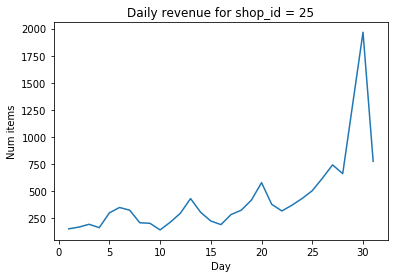

In [26]:
# Plot it
plt.plot(days, total_num_items_sold)
plt.ylabel('Num items')
plt.xlabel('Day')
plt.title("Daily revenue for shop_id = 25")
plt.show()


## Aggregate Volumes

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings.


In [33]:
def agg_sales(all_sales, sales, groupby_cols, agg_col_name):
    '''
    aggregate volumes 
    '''

    # aggregate
    aggregated_sales = (sales
        .groupby(groupby_cols, as_index=False)
        .agg({'item_cnt_day':'sum'})
        .rename(columns={'item_cnt_day': agg_col_name})
    )

    # merge with main df
    df = pd.merge(all_sales, aggregated_sales, how='left', on=groupby_cols).fillna(0)
    return df


In [34]:
# columns for which to create a unique key (date_block_num is the month number)
index_cols = ['date_block_num', 'shop_id', 'item_id']
shop_month_cols = ['date_block_num', 'shop_id']
item_month_cols = ['date_block_num', 'item_id']


In [38]:
# unique shops & items per month
shops = transactions[['date_block_num', 'shop_id']].drop_duplicates()
items = transactions[['date_block_num', 'item_id']].drop_duplicates()
 
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = shops.loc[shops['date_block_num'] == block_num, 'shop_id']
    cur_items = items.loc[items['date_block_num'] == block_num, 'item_id']
    cur_items_shops = list(product(*[[block_num], cur_shops, cur_items]))
    grid += cur_items_shops

# convert to dataframe
grid = pd.DataFrame(np.array(grid), columns = index_cols, dtype=np.int32) 


In [39]:
# aggregate data
all_data = agg_sales(grid, transactions, index_cols, 'target')
all_data = agg_sales(all_data, transactions, shop_month_cols, 'target_shop')
all_data = agg_sales(all_data, transactions, item_month_cols, 'target_item')


In [55]:
# sort the data
all_data.sort_values(index_cols,inplace=True)
all_data.head()


,date_block_num,shop_id,item_id,target,target_shop,target_item
139255,0,0,19,0.0,5578.0,1.0
141495,0,0,27,0.0,5578.0,7.0
144968,0,0,28,0.0,5578.0,8.0
142661,0,0,29,0.0,5578.0,4.0
138947,0,0,32,6.0,5578.0,299.0


___

# Mean Encoding
## Global Mean

In [50]:
# global mean
global_mean = all_data['target'].mean()
'global mean: {:.4f}'.format(global_mean)


'global mean: 0.3343'

## Without Regularization


In [64]:
# new df
df_new = all_data.copy(deep=True)

# add the mean of each item to item_target_enc
df_new['item_target_enc'] = df_new.groupby('item_id')['target'].transform('mean')

# fill nan with global_mean
df_new['item_target_enc'].fillna(global_mean, inplace=True) 

# correlation
print(np.corrcoef(df_new['target'], df_new['item_target_enc'].values)[0][1])


0.48303869886217826


## KFold

In [65]:
# new df
df_new = all_data.copy(deep=True)

# add the mean of each item to item_target_enc
k_fold = KFold(5, shuffle=False)
for ftrain_idx, fval_idx in k_fold.split(df_new['target']):
    # split fold in train/val
    ftrain = df_new.iloc[ftrain_idx]
    means = ftrain.groupby('item_id')['target'].mean()
    df_new.loc[fval_idx, 'item_target_enc'] = df_new.loc[fval_idx, 'item_id'].map(means)

# fill nan with global_mean
df_new['item_target_enc'].fillna(global_mean, inplace=True) 

# correlation
print(np.corrcoef(df_new['target'], df_new['item_target_enc'].values)[0][1])


0.4165079504415114


## LOO

Using the KFold code with K = all_data.shape[0] would take a very long time. To calculate the mean target value using all the objects but one, we can:

1. Calculate sum of the target values using all the objects.
2. Subtract the target of the *given object* and divide the resulting value by `n_objects - 1`. 


In [66]:
# for each row i, the mean encoding is:
# ° the sum of its class minus its value, 
# ° divided by the number of items of the class minus one

# new df
df_new = all_data.copy(deep=True)

# add the mean of each item to item_target_enc
df_new['item_target_enc'] = (
    (df_new.groupby('item_id')['target'].transform('sum') - df_new['target']) / # sum minus own value
    (df_new.groupby('item_id')['target'].transform('count') - 1)                # count minus one
).fillna(global_mean, inplace=True)

# fill nan with global_mean
df_new['item_target_enc'].fillna(global_mean, inplace=True) 

# correlation
print(np.corrcoef(df_new['target'], df_new['item_target_enc'].values)[0][1])


0.4803848297354129


## Smoothing


In [67]:
# new df
df_new = all_data.copy(deep=True)

# add the mean of each item to item_target_enc
df_new['item_target_enc'] = (
    (
        (df_new.groupby('item_id')['target'].transform('mean') *
         df_new.groupby('item_id')['target'].transform('count'))
        + global_mean * 100
    ) /
    (df_new.groupby('item_id')['target'].transform('count') + 100)
)

# correlation
print(np.corrcoef(df_new['target'], df_new['item_target_enc'].values)[0][1])


0.48181988922288893


## Expanding Mean

In [68]:
# new df
df_new = all_data.copy(deep=True)

# expanding mean
cumsum = df_new.groupby('item_id')['target'].cumsum() - df_new['target'] # cumsum of [0..n-1]
cumcnt = df_new.groupby('item_id')['target'].cumcount()                  # cumcnt of [0..n-1]
df_new['item_target_enc'] = cumsum / cumcnt

# fill nan with global_mean
df_new['item_target_enc'].fillna(global_mean, inplace=True) 

# correlation
print(np.corrcoef(df_new['target'], df_new['item_target_enc'].values)[0][1])


0.5025245187658264


___

# Lag Features
